In [14]:
!git clone https://github.com/theiresearch/ArcticSeaIce.git

fatal: destination path 'ArcticSeaIce' already exists and is not an empty directory.


In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns # contains barplot
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error

from sklearn.linear_model import LassoCV # lasso linear model with cross-validation
from sklearn.ensemble import RandomForestRegressor # random forest
from sklearn.ensemble import GradientBoostingRegressor # gradient boosting
from sklearn.neural_network import MLPRegressor # multiplayer perceptron

In [16]:
# reading the data
df = pd.read_csv("/content/ArcticSeaIce/data/arctic_data.csv")
#df.describe()

In [17]:
df['V_shift'] = df['ArcticIceVolume'].shift()
df['Volume_vary'] = df['ArcticIceVolume'] - df['V_shift']
del df['V_shift']
df = df.dropna()

temp = df[['MinTemperature_NorthSlopeAlaska']] # x
delta_vol = df[['Volume_vary']] # y

In [18]:
# split traing set and testing set to 9:1 (441:49):
X_train, X_val, y_train, y_val = train_test_split(temp, delta_vol, test_size=0.1, \
                                                                    train_size=0.9, random_state=7)
X_train.shape, X_val.shape

((440, 1), (49, 1))

In [19]:
experiments = []
metric_names = []
metric_vals = []

In [20]:
# tracking experiment results
def plot_preds(y_pred, y_val):
    '''Plot predictions vs labels on a scatter plot.'''
    lines_color = plt.rcParams['text.color']
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)
    plt.plot([-0.25, 0.2], [-0.25, 0.2], c='red', zorder=1)
    plt.scatter(y_val, y_pred, alpha=0.6, edgecolors=lines_color, c='#5EC2FF')
    #ax.set_aspect('equal', adjustable='box')
    ax.grid(linestyle='--')
    plt.xlabel('True value')
    plt.ylabel('Predictions')
    plt.show()

def calc_metrics(y_pred, y_val):
    '''Print 4 metrics using predictions and labels.'''
    r2 = r2_score(y_val, y_pred)
    ev = explained_variance_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    return r2, ev, mse, mae

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model: LassoCV(cv=10, n_alphas=1000, random_state=0)
Predictions: (49,)


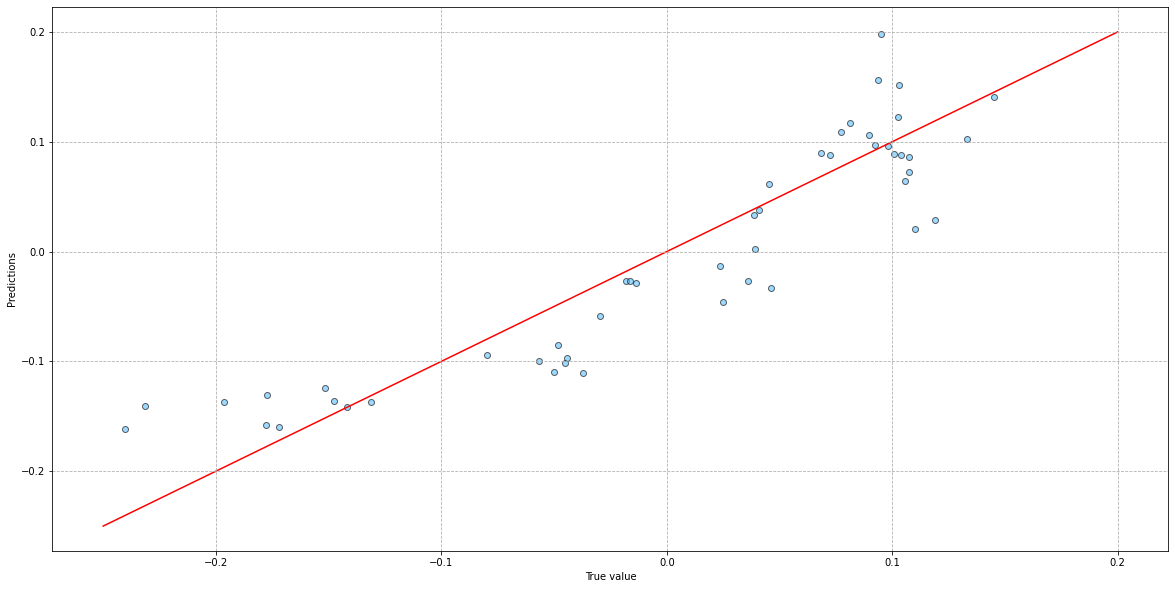

R2 Score: 0.821460236
Explained Variance Score: 0.825101191
MSE: 0.002058589
MAE: 0.036025229
2.944531155335314e-05


In [21]:
lassoMLR_cv_model = LassoCV(
    cv=10, random_state=0, n_alphas=1000
).fit(X_train, y_train)
y_pred = lassoMLR_cv_model.predict(X_val)
print(f'Model: {lassoMLR_cv_model}')
print(f'Predictions: {y_pred.shape}')

# plot
plot_preds(y_pred, y_val)
r2, ev, mse, mae = calc_metrics(y_pred, y_val)
print(f'R2 Score: {r2:.9f}')
print(f'Explained Variance Score: {ev:.9f}')
print(f'MSE: {mse:.9f}')
print(f'MAE: {mae:.9f}')
# Update overall results, if we haven't already:
if 'LassoLinearModel' not in experiments:
    experiments.extend(['LassoLinearModel']*4)
    metric_names.extend(['R2', 'Explained Variance', 'MSE', 'MAE'])
    metric_vals.extend([r2, ev, mse, mae])


print(lassoMLR_cv_model.alpha_)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Model: RandomForestRegressor(max_depth=20, n_estimators=2000, random_state=7)
Predictions: (49,)


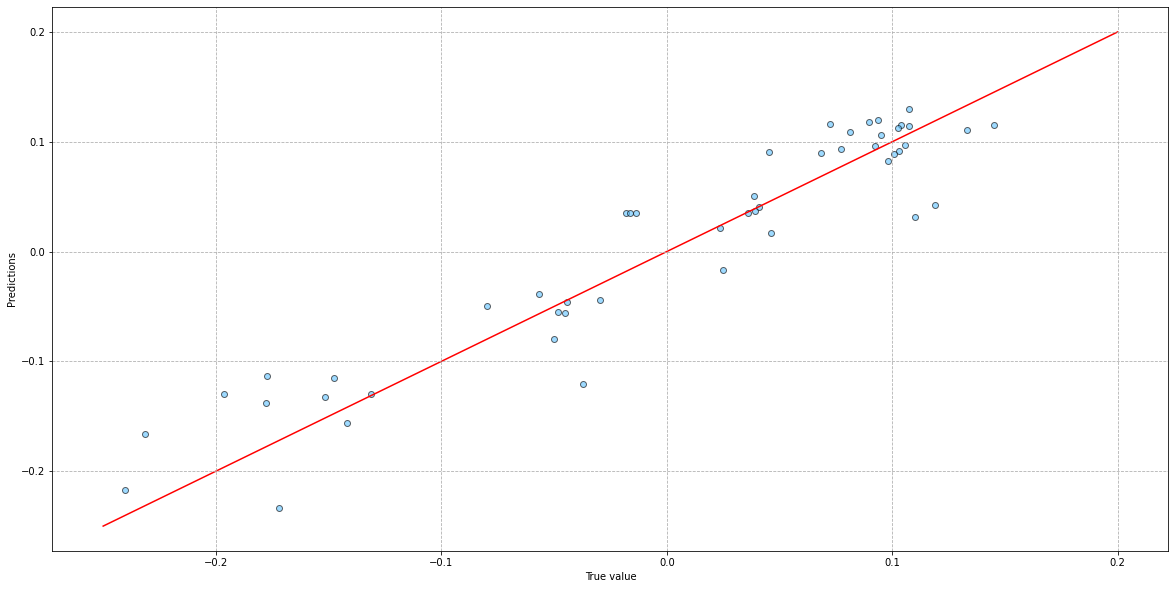

R2 Score: 0.890018770
Explained Variance Score: 0.892124426
MSE: 0.001268099
MAE: 0.027640975


In [22]:
random_forest_model = RandomForestRegressor(
    n_estimators=2000,
    max_depth=20,
    random_state=7
).fit(X_train, y_train)
y_pred = random_forest_model.predict(X_val)
print(f'Model: {random_forest_model}')
print(f'Predictions: {y_pred.shape}')

#plot
plot_preds(y_pred, y_val)
r2, ev, mse, mae = calc_metrics(y_pred, y_val)
print(f'R2 Score: {r2:.9f}')
print(f'Explained Variance Score: {ev:.9f}')
print(f'MSE: {mse:.9f}')
print(f'MAE: {mae:.9f}')
# Update overall results, if we haven't already:
if 'RandomForestModel' not in experiments:
    experiments.extend(['RandomForestModel']*4)
    metric_names.extend(['R2', 'Explained Variance', 'MSE', 'MAE'])
    metric_vals.extend([r2, ev, mse, mae])

Model: MLPRegressor(batch_size=32, hidden_layer_sizes=(10, 10, 10, 10, 10, 10),
             random_state=0, solver='lbfgs')
Predictions: (49,)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


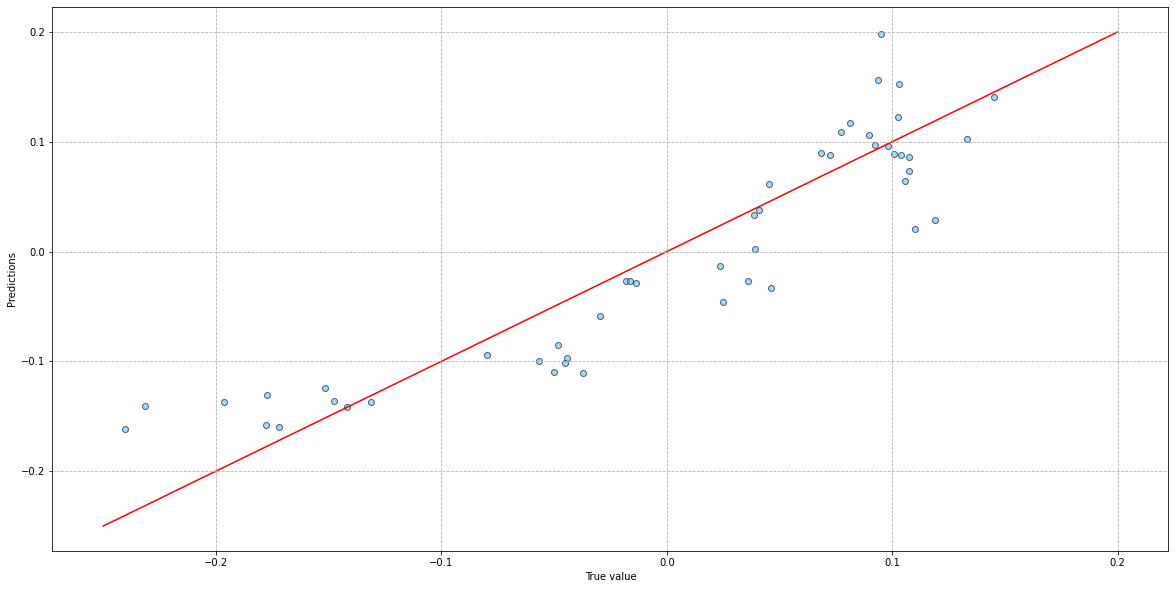

R2 Score: 0.821488907
Explained Variance Score: 0.825044046
MSE: 0.002058258
MAE: 0.036013082


In [23]:
# optimizing MLP hyperparameter
nn = MLPRegressor(
    hidden_layer_sizes=(10,10,10,10,10,10), 
    batch_size=32,
    activation='relu',
    solver='lbfgs', #lbfgs, sgd, adam
    random_state=0,
).fit(X_train, y_train)
y_pred = nn.predict(X_val)
print(f'Model: {nn}')
print(f'Predictions: {y_pred.shape}')

# plot
plot_preds(y_pred, y_val)
r2, ev, mse, mae = calc_metrics(y_pred, y_val)
print(f'R2 Score: {r2:.9f}')
print(f'Explained Variance Score: {ev:.9f}')
print(f'MSE: {mse:.9f}')
print(f'MAE: {mae:.9f}')
# Update overall results, if we haven't already:
if 'AdvancedNN' not in experiments:
    experiments.extend(['AdvancedNN']*4)
    metric_names.extend(['R2', 'Explained Variance', 'MSE', 'MAE'])
    metric_vals.extend([r2, ev, mse, mae])

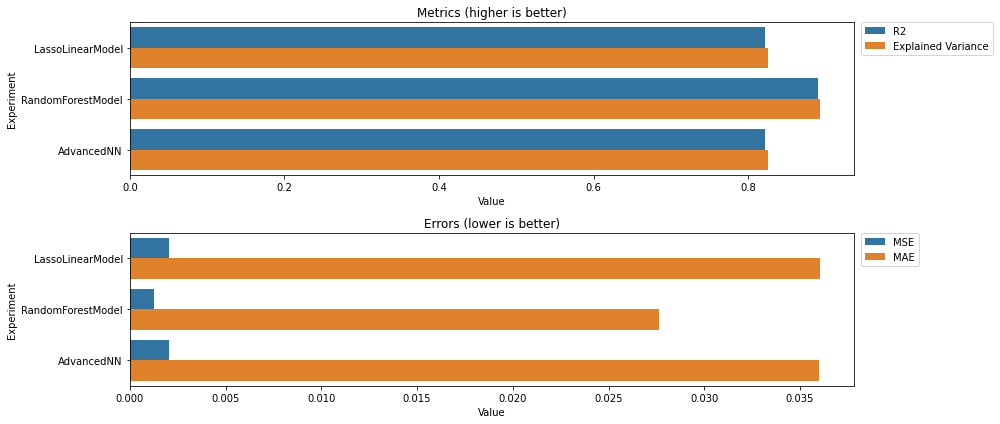

           Experiment              Metric     Value
0    LassoLinearModel                  R2  0.821460
1    LassoLinearModel  Explained Variance  0.825101
2    LassoLinearModel                 MSE  0.002059
3    LassoLinearModel                 MAE  0.036025
4   RandomForestModel                  R2  0.890019
5   RandomForestModel  Explained Variance  0.892124
6   RandomForestModel                 MSE  0.001268
7   RandomForestModel                 MAE  0.027641
8          AdvancedNN                  R2  0.821489
9          AdvancedNN  Explained Variance  0.825044
10         AdvancedNN                 MSE  0.002058
11         AdvancedNN                 MAE  0.036013


In [24]:
# comparing models
df_res = pd.DataFrame()
df_res['Experiment'] = experiments
df_res['Metric'] = metric_names
df_res['Value'] = metric_vals
#df_res.head()

# barplot metrics and errors
fig, axes = plt.subplots(2, 1, figsize=(14, 6))
sns.barplot(
    data=df_res[df_res.Metric.isin(['R2', 'Explained Variance'])],
    orient='h',
    x='Value',
    y='Experiment',
    hue='Metric',
    ax=axes[0]
)
axes[0].set_title('Metrics (higher is better)')
axes[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
sns.barplot(
    data=df_res[~df_res.Metric.isin(['R2', 'Explained Variance'])],
    orient='h',
    x='Value',
    y='Experiment',
    hue='Metric',
    ax=axes[1],
)
axes[1].set_title('Errors (lower is better)')
axes[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

print(df_res)